# Day-Averaged Yearly Profiles clustering

In [2]:
import polars as pl
import re
import glob
import numpy as np
import os
import matplotlib.pyplot as plt
import logging
from datetime import date, datetime
from datetime import timedelta
from pathlib import Path

from tslearn.clustering import TimeSeriesKMeans 
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans

from validation import validation
from Hyperparameters_KMeans import optimize_kmeans

logging.getLogger('matplotlib.font_manager').disabled = True

timestamp_range = pl.datetime_range(datetime(2024, 1, 1), datetime(2024, 12, 31), "1d", eager=True).cast(pl.Date)

## Extracting and preparing files for clustering

In [3]:
def day_avg_preprocess(df, timestamp_range):
    
    df = df.with_columns(
        pl.col("zeitpunkt").str.strptime(pl.Datetime, format="%Y-%m-%dT%H:%M:%S%z", strict=False).alias("zeitpunkt_dt")
    )
    
    df = df.with_columns(
        pl.col("zeitpunkt_dt").dt.date().alias("date")
    )

    date_list = timestamp_range.to_list()

    day_avg = (
        df.filter(pl.col("date").is_in(date_list))
          .group_by("date")
          .agg(pl.col("bruttolastgang_kwh").mean().alias("day_avg_bruttolastgang_kwh"))
          .sort("date")
    )
    return day_avg

def normalize(df):
    """ Normalize the 'day_avg_bruttolastgang_kwh' column by its max value and overwrite the original column """
    
    max_val = df.select(pl.max("day_avg_bruttolastgang_kwh"))['day_avg_bruttolastgang_kwh'][0]
    
    if max_val == 0:
        # Avoid division by zero, leave values unchanged
        df = df.with_columns(
            pl.col("day_avg_bruttolastgang_kwh")
        )
    else:
        # Overwrite original column with normalized values
        df = df.with_columns(
            (pl.col("day_avg_bruttolastgang_kwh") / max_val).alias("day_avg_bruttolastgang_kwh")
        )
    
    df = df.sort("date")
    
    return df

# Define the input file pattern
pattern = "/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_cleaned/*CH*.csv"
file_paths = glob.glob(pattern)

# Define the output directory
output_dir = Path("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_day_avg_normalized")
output_dir.mkdir(parents=True, exist_ok=True)

for file_path in file_paths:
    df = pl.read_csv(file_path)
    day_avg = day_avg_preprocess(df, timestamp_range)
    day_avg = normalize(day_avg)
    
    filename = os.path.basename(file_path)  # gets file name with extension
    output_file = output_dir / filename      # construct output path
    
    day_avg.write_csv(output_file)

    

## Daily-average Clustering over the year 2024

In [4]:
input_folder = Path("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/SM_DATA_day_avg_normalized")

pattern = str(input_folder / "*CH*.csv")
file_paths = glob.glob(pattern)

In [5]:
n_timestamps = len(timestamp_range)

data_list = []
filename_list = []

pattern = re.compile(r"(CH[^_\.]*)")  # Matches 'CH' followed by any chars except _ or .

for idx, file_path in enumerate(file_paths):
    df = pl.read_csv(file_path)
    if len(df) == n_timestamps:
        values_array = df["day_avg_bruttolastgang_kwh"].to_numpy().reshape((1, n_timestamps, 1))
        data_list.append(values_array)
        
        base = os.path.basename(file_path)
        match = pattern.search(base)
        if match:
            filename_list.append(match.group(1))
        else:
            filename_list.append(base)  # fallback to full basename if no CH... found

if data_list:
    data_3d = np.concatenate(data_list, axis=0)
    print(f"Shape of the 3D array: {data_3d.shape}")

print(filename_list[:10])  # Preview first 10 extracted CH... names

train_data = data_3d



Shape of the 3D array: (1464, 366, 1)
['CH1018601234500000000000000040851', 'CH1018601234500000000000000047828', 'CH1018601234500000000000000112970', 'CH1018601234500000000000000076787', 'CH1018601234500000000000000067786', 'CH1018601234500000000000000036798', 'CH1018601234500000000000000065363', 'CH1018601234500000000000000065862', 'CH1018601234500000000000000024655', 'CH1018601234500000000000000070197']


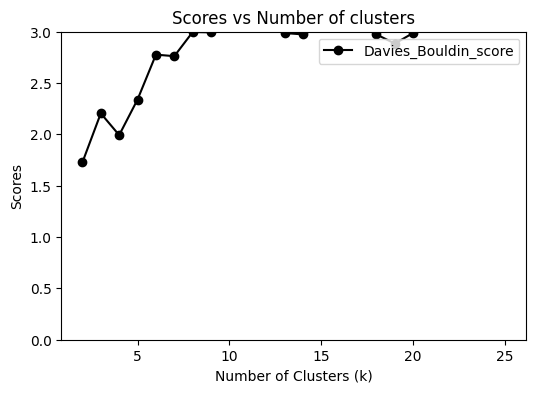

1.7273212063122658

Best combination of hyperparameters:
n_clusters                  4
init                k-means++
n_init                      1
max_iter                  100
silhouette_score     0.130058
db_score              1.99298
Name: 25, dtype: object


n_clusters                  4
init                k-means++
n_init                      1
max_iter                  100
silhouette_score     0.130058
db_score              1.99298
Name: 25, dtype: object

In [6]:
validation(train_data)

optimize_kmeans(train_data)


In [11]:


n_clusters = 4  # Number of clusters, you can adjust this
max_iterations =100

kmeans = TimeSeriesKMeans(n_clusters=n_clusters,max_iter=max_iterations, verbose=False, random_state=42, n_jobs=-1)
clusters_train = kmeans.fit_predict(train_data)

In [12]:
# saves the found clusters in a csv file with the corresponding household IDs

# Convert filename_list items to strings
house_ids = [str(h) for h in filename_list]

# Creates Polars DataFrame with house IDs and clusters
result_df = pl.DataFrame({
    "house_id": house_ids,
    "cluster": clusters_train + 1
}).sort("cluster")
result_df.write_csv("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/day_avg_clustering.csv")

In [13]:
# total number of households per cluster, total energy consumption per cluster, averga eenergy consumption per cluster daily and anually

# Convert filename_list items to strings if not already
house_ids = [str(h) for h in filename_list]

# Create Polars DataFrame with house IDs and clusters
result_df = pl.DataFrame({
    "house_id": house_ids,
    "cluster": clusters_train + 1  # adjust if needed
})

# Read the alle_mittelwerte file
alle_mittelwerte_df = pl.read_csv("/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/alle_mittelwerte.csv")  # Adjust path as needed

# Normalize keys in all DataFrames for clean join
# Normalize keys
result_df = result_df.with_columns(
    pl.col("house_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

alle_mittelwerte_df = alle_mittelwerte_df.with_columns(
    pl.col("file_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("ch_id_clean")
)

result_df = result_df.join(
    alle_mittelwerte_df.select([
        "ch_id_clean",
        "bruttolastgang_kwh_sum",
        "average_daily_consumption"
    ]),
    on="ch_id_clean",
    how="left"
)
# Now select in the desired order
result_df = result_df.select([
    "house_id",
    "cluster",
    "bruttolastgang_kwh_sum",
    "average_daily_consumption"  
])

#print(result_df.head())

cluster_summary = result_df.group_by("cluster").agg([
    pl.count("house_id").alias("num_households"),
    pl.mean("bruttolastgang_kwh_sum").alias("avg_yearly_consumption [kWh]"),
    pl.mean("average_daily_consumption").alias("avg_daily_consumption [kWh]")
]).sort("cluster")

print(cluster_summary)

shape: (4, 4)
┌─────────┬────────────────┬──────────────────────────────┬─────────────────────────────┐
│ cluster ┆ num_households ┆ avg_yearly_consumption [kWh] ┆ avg_daily_consumption [kWh] │
│ ---     ┆ ---            ┆ ---                          ┆ ---                         │
│ i64     ┆ u32            ┆ f64                          ┆ f64                         │
╞═════════╪════════════════╪══════════════════════════════╪═════════════════════════════╡
│ 1       ┆ 307            ┆ 3002.726238                  ┆ 5.029411                    │
│ 2       ┆ 408            ┆ 5028.40086                   ┆ 8.910476                    │
│ 3       ┆ 581            ┆ 3305.854775                  ┆ 5.661155                    │
│ 4       ┆ 168            ┆ 9471.606018                  ┆ 14.980012                   │
└─────────┴────────────────┴──────────────────────────────┴─────────────────────────────┘


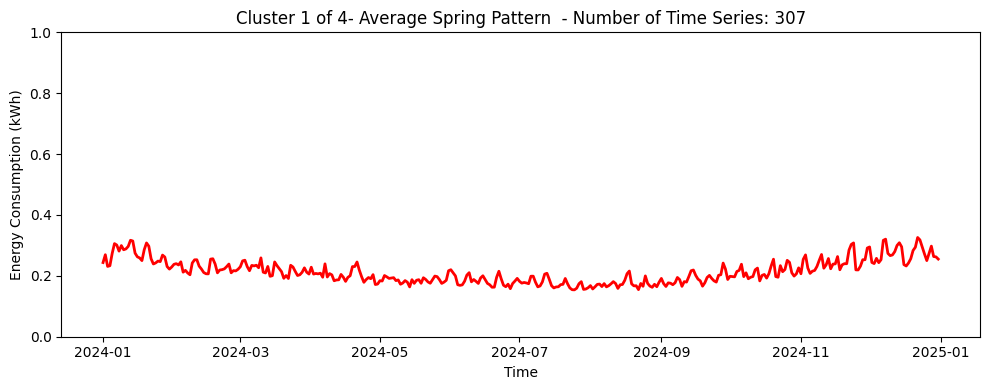

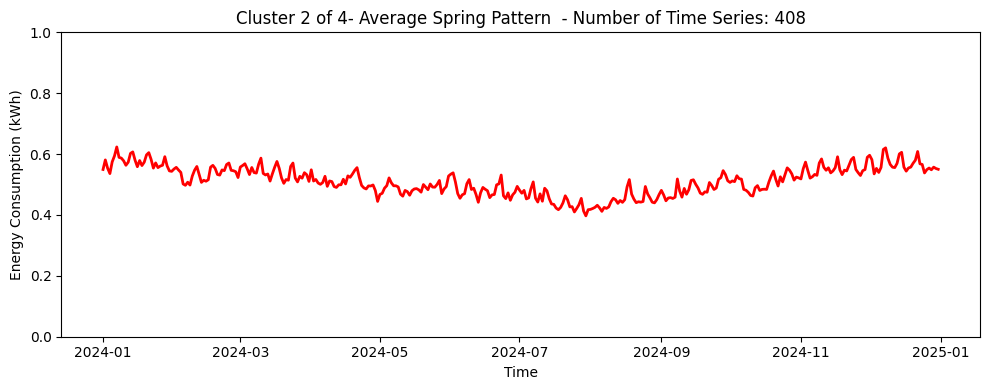

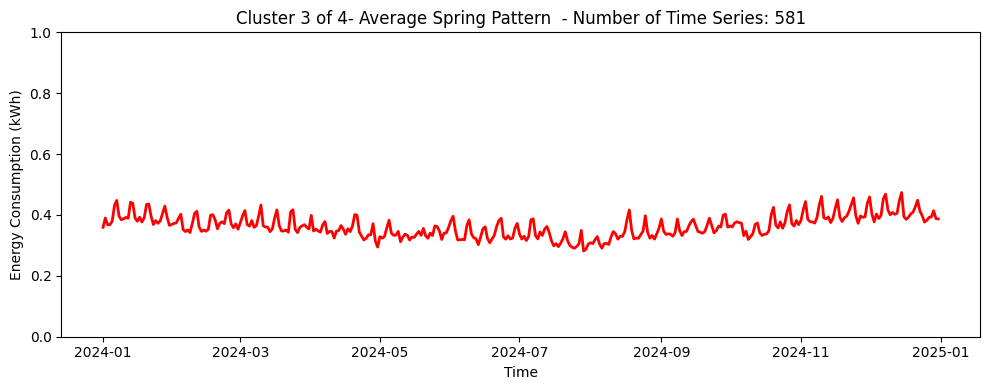

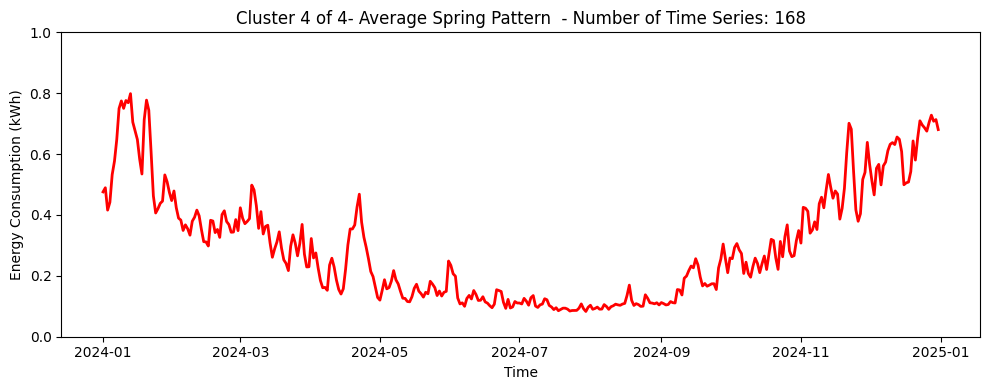

In [14]:
save = 0 #if you want to save the plots save = 1 and add path
plot_range = timestamp_range
for cluster_idx in range(n_clusters):
    # Get all time series in this cluster
    cluster_data = train_data[clusters_train == cluster_idx]
    cluster_indices = np.where(clusters_train == cluster_idx)[0]    
    
    # Calculate the mean time series for the cluster
    mean_time_series = np.mean(cluster_data, axis=0)
    
    # Plot the mean time series
    plt.figure(figsize=(10, 4))

    plt.plot(plot_range, mean_time_series.ravel(), linewidth =2, color='red' )
    cluster_no = cluster_idx+1
    plt.title(f"Cluster {cluster_no} of {n_clusters}- Average Spring Pattern  - Number of Time Series: {len(cluster_indices)}")
    plt.xlabel("Time")
    plt.ylabel("Energy Consumption (kWh)")
    plt.xticks()
    plt.ylim(0,1)
    plt.tight_layout()
    #plt.legend()
    #plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.show()